<b><font color='darkred'> Verwenden statistischer Größen der Zeitreihen als Features <br>

#  <b> Logistische Regression (für Klassifikation) & Lineare Regression (für Regression)


-----------------
- Power[W] &nbsp;&emsp;&emsp; ➔  Generatorleistung, Energie &emsp;➔ p
- Force[N] &emsp;&emsp;&emsp;➔  Pressenkraft &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➔ f
- Distance[mm] &nbsp;➔  Sonotrodenvorschub &emsp;&emsp;&emsp;&emsp;➔ d
- [ms] &emsp;&emsp;&emsp;&emsp;&emsp;➔  Zeit &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&emsp;&emsp;&emsp;➔ t


In [3]:
import numpy as np
from sklearn import model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
pca = False      # PCA Anwendung ja oder nein?
n_components = 0.98

SCALE = 2000    # Skalierung für Zielvariable Zugfestigkeit

STATS = [
    # Power (p_*)
    "p_mean", "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_iqr", "p_f_ratio", "p_d_ratio", "p_t_ratio",
    
    # Force (f_*)
    #"f_mean", "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_iqr", "f_d_ratio", "f_t_ratio",
    
    # Distance (d_*)
    "d_mean", "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_iqr", "d_t_ratio", "d_b75",
    
    # Zeitmerkmale
    "t_max",
]


# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [6]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [7]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [8]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalieren Trainings- und Testdaten mit PCA

In [9]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

In [10]:
if pca == True:
    pca_scaler = PCA(n_components=n_components)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

<b><font color='lightgreen'> Kontrollanzeige t-SNE

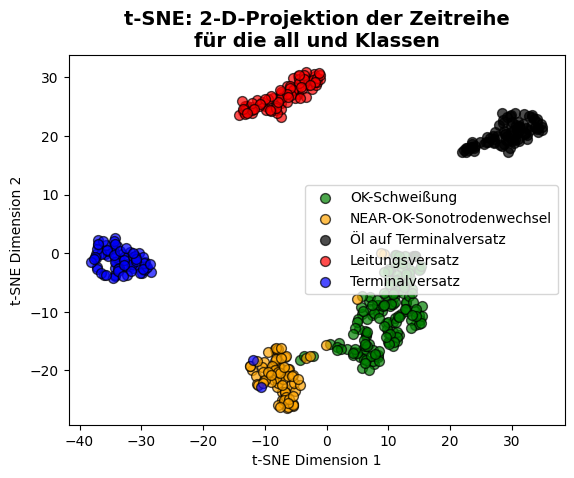

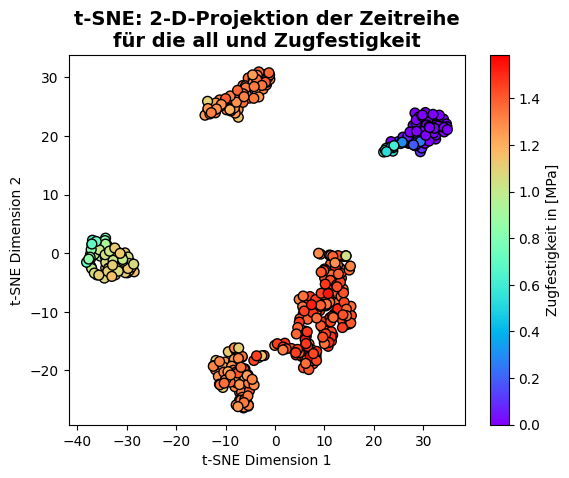

In [11]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> Logistische Regression (Hyperparametersuche - Random Search)

In [12]:
# Hyperparameter-Suche
log_reg_params = {
    "C": np.logspace(0, 4),  # Inverse Regularisierung (kleinere Werte = stärkere Regularisierung)
    "max_iter": [5000, 5500, 6000, 6500, 7000, 8000, 9000],  # Anzahl der Iterationen
    "solver": ["lbfgs", "saga"],   # Optimierungsalgorithmen
}

log_reg_search = model_selection.RandomizedSearchCV(
    LogisticRegression(), 
    log_reg_params, 
    n_iter=100, 
    #scoring="accuracy", 
    cv=3, 
    n_jobs=-1, 
    random_state=42
)
log_reg_search.fit(X_train_scaled, label_train)
modelSVC_best = log_reg_search.best_estimator_

# Vorhersage
pred_train = modelSVC_best.predict(X_train_scaled)
pred_test  = modelSVC_best.predict(X_test_scaled)

modelSVC_best

LogisticRegression(C=1.4563484775012439, max_iter=5500, solver='saga')

<b><font color='lightgreen'> Modellbewertung</b>

In [13]:
helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     1.000     1.000        43
   near_ok_sonowechsel      1.000     1.000     1.000        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     1.000     1.000        24

              accuracy                          1.000       120
             macro avg      1.000     1.000     1.000       120
          weighted avg      1.000     1.000     1.000       120



,Train,Test
Metric,,
Accuracy,0.990,1.000
Precision,0.990,1.000
Recall,0.990,1.000
F1-score,0.990,1.000


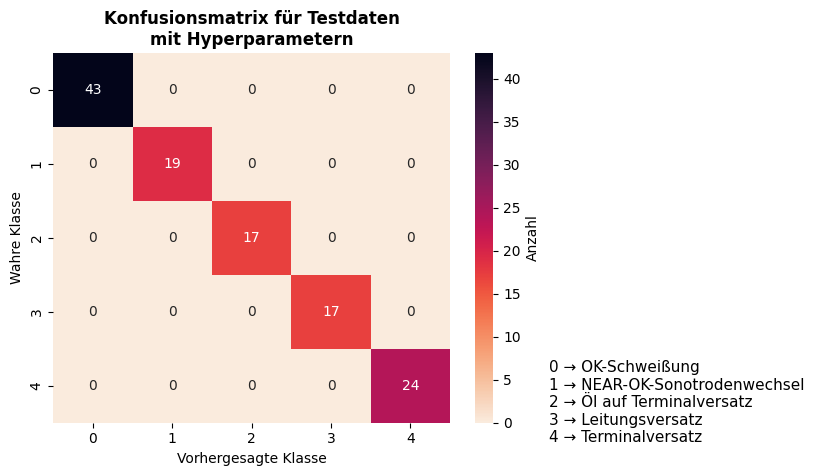

In [14]:
helper.plot_confusion(label_test, pred_test, 'Testdaten\nmit Hyperparametern')

<b><font color='lightgreen'><h3> Lineare Regression (Hyperparameter GridSearch) </b>

In [15]:
# Hyperparameter-Suche 
lin_reg_params = {
    "fit_intercept": [True, False],  # Soll ein Bias-Term eingebaut werden?
    "positive": [True, False],       # Sollen nur positive Koeffizienten erlaubt sein?
}
"""
lin_reg_search = model_selection.RandomizedSearchCV(
    LinearRegression(), 
    lin_reg_params, 
    n_iter=4, # 4 = maximal mögliche Kombinationen
    #scoring="neg_mean_squared_error", 
    cv=5, 
    n_jobs=-1, 
    random_state=42
)"""
# da es nur 4 mögliche Kombinationen gibt, direkt GridSearch verwenden:
lin_reg_search = model_selection.GridSearchCV(
    LinearRegression(), 
    lin_reg_params, 
    #scoring="neg_mean_squared_error", 
    cv=5, 
    n_jobs=-1
)
lin_reg_search.fit(X_train_scaled, festigkeit_train)
best_estimator = lin_reg_search.best_estimator_

# Vorhersage
y_pred_train = best_estimator.predict(X_train_scaled)
y_pred_test  = best_estimator.predict(X_test_scaled)

best_estimator

LinearRegression()

In [16]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,59025.34,55356.58
RMSE,242.95,235.28
MAE,188.89,195.46
R²,0.93,0.93


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

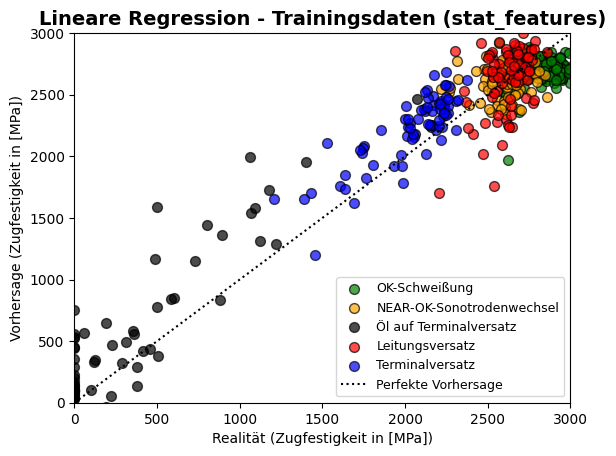

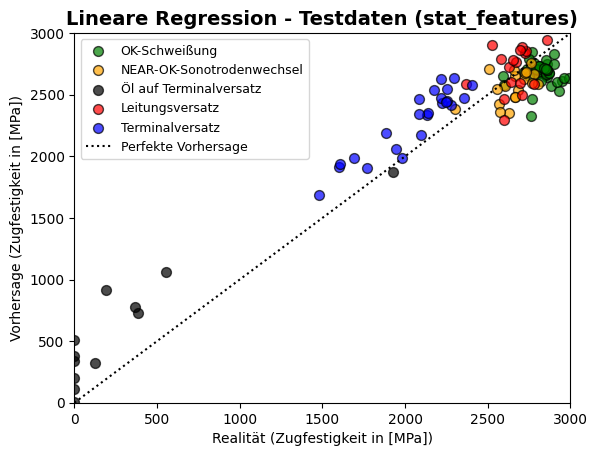

In [17]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'Lineare Regression - Trainingsdaten (stat_features)', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'Lineare Regression - Testdaten (stat_features)', 'mit Linie', SCALE)